In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()

  Activating environment at `~/.julia/dev/StableManipulation/Project.toml`


In [2]:
using LinearAlgebra
using ForwardDiff
using OrdinaryDiffEq
using Plots
using Convex, SCS
using JLD
using StableManipulation

In [25]:
# (1) system properties and contact

const g = 9.81

const m = 1
const μ = 0.5 # pusher-slider friction coefficient

const w = 1.0 # width of the slider (x axis)
const h = 1.0 # height of the slider (y aixs)

const M = [m 0 0; 0 m 0; 0 0 m*((h/2)^2+(w/2)^2)/3] # inertia matrix

const A_ls = [1 0 0; 0 1 0; 0 0 1.5] # ellipsoid limit surface

const modes = [0 0; # free
            1 0; # sticking
            1 1; # right slide 
            1 -1] # left slide

const n_contacts = 1 

# simulation step size
const Δt = 0.05
# tolerance for contacts
const tol_c = 1e-5

# q = [x_s, y_s, θ_s, x_p, y_p]

# 2D rotation matrix
function R_2D(θ)
    R = [cos(θ) -sin(θ); sin(θ) cos(θ)]
    return R
end

R_2D (generic function with 1 method)

In [26]:
# only consider the block is pushed on the edge of x = -w/2 
function compute_a(q)
    p = q[4:5]
    p1 = R_2D(q[3])*[-w/2; -h/2] + q[1:2]
    p2 = R_2D(q[3])*[-w/2; h/2] + q[1:2]
    d = -((p2[1] - p1[1])*(p1[2] - p[2]) - (p1[1] - p[1])*(p2[2] - p1[2]))/w
    return d
end

compute_a (generic function with 1 method)

In [27]:
function compute_A(q)
    A = ForwardDiff.gradient(compute_a, q)
    return A
end

compute_A (generic function with 1 method)

In [31]:
function motion_cone(vp, p)
    # vp: pusher velocity in the body frame
    # p: pusher location in the body frame (assume pusher make contact with x = -w/2 edge)

    # return (pusher motion relative to the slider)
    # 0 sticking, 1 right slide, -1 left slide

    Jp = [1 0 -p[2]; 0 1 p[1]]

    fl = [1; -μ]
    fr = [1; μ]

    Fl = Jp'*fl
    Fr = Jp'*fr

    Vl = A_ls*Fl
    Vr = A_ls*Fr

    vl = Jp*Vl # vl[1] > 0, vl[2] < 0, slider sliding to the left of the pusher
    vr = Jp*Vr # vr[1] > 0, vr[2] > 0, slider sliding to the right of the pusher 

    if vp[2]/vp[1] > vr[2]/vr[1]
        return 1
    elseif vp[2]/vp[1] < vl[2]/vl[1]
        return -1
    end
    
    return 0
end

motion_cone (generic function with 1 method)

In [128]:
# quasi-static: x = q
function solveEOM(x, u_control)
    # u_control: velocity of the pusher in the world frame
    if (abs(compute_a(x)) > tol_c)
        return [0;0;0;u_control]
    end

    R_WO = R_2D(x[3])
    vp = R_WO'*u_control
    p = R_WO'*(x[4:5] .- x[1:2])

    if (vp[1] < 0) || (abs(p[2]) > h/2)
        # leaving
        return [0;0;0;u_control]
    end
    
    mc = motion_cone(vp, p)

    Jp = [1 0 -p[2]; 0 1 p[1]]

    fl = [1; -μ]
    fr = [1; μ]

    Fl = Jp'*fl
    Fr = Jp'*fr

    if mc == 0
        # println("stick")
        t = [-p[2];p[1];-1]
        D = [Jp' inv(A_ls)*t]'
        Vp = [vp;0]
        V = inv(D)*Vp
    else
        if mc == 1
            # println("right slide")
            V = A*Fr
        else
            # println("left slide")
            V = A*Fl
        end
        k = vp[1]/(V[1] - V[3]*p[2])
        V = k*V
    end

    V_w = [R_WO [0;0];0 0 1]*V

    return [V_w; u_control]
end

solveEOM (generic function with 1 method)

In [129]:
function ode_dynamics!(dx, x, p, t)
    # p from integrator: (contact mode, controller, t_control, h_control, u_control)
    

    contactMode = p[1]
    controller = p[2]
    t_control = p[3][1]
    h_control = p[4]
    u_control = zeros(2)
    u_control .= p[5]
    
    if t > (t_control + h_control)
        p[3] .= [Float64(t)]
        u_control = controller(x)
        p[5] .= u_control
    end
    

    dx .= solveEOM(x, u_control)

end

ode_dynamics! (generic function with 1 method)

In [130]:
function ode_conditions(out, x, t, integrator)
    c = compute_a(x)
    out .= c
end

ode_conditions (generic function with 1 method)

In [131]:
function ode_affect_neg!(integrator, idx)
    # if debug == true
    #     println("down crossing.")
    # end
    # u_control = controller(x)
    # integrator.p[5] .= u_control
end

ode_affect_neg! (generic function with 1 method)

In [160]:
function push_controller(x)
    return [0.5;0.3]
end

push_controller (generic function with 1 method)

In [164]:
controller = push_controller
h_control = Δt

tspan = (0.0, 4.0)

x0 = [0;0;0;-w;-0.5]

prob = ODEProblem(ode_dynamics!, x0, tspan, ([0], controller, [0.0], h_control, controller(x0)))
cb = VectorContinuousCallback(ode_conditions, nothing, ode_affect_neg!, 1)

sol = solve(prob, Tsit5(); callback = cb, abstol=1e-15,reltol=1e-15, adaptive=false,dt=Δt)

println("Simulation status: ", sol.retcode)

Simulation status: Success


In [165]:
function boxshape(q)
    p1 = q[1:2] + R_2D(q[3])*[w/2;h/2]
    p2 = q[1:2] + R_2D(q[3])*[w/2;-h/2]
    p3 = q[1:2] + R_2D(q[3])*[-w/2;-h/2]
    p4 = q[1:2] + R_2D(q[3])*[-w/2;h/2]
    pp = [p1 p2 p3 p4]
    return Shape(pp[1,:], pp[2,:])
end

function animation(x, n, fps = 30)
    anim = Plots.Animation()
    for i ∈ 1:n
        p = plot(boxshape([x[i][1],x[i][2],x[i][3]]), aspect_ratio=:equal, c=:gray, opacity=.7, legend=false)
        scatter!(p,[x[i][4]],[x[i][5]], markersize=5, xlims=(-2,2), ylims=(-2,2))
        frame(anim, p)
    end
    Plots.gif(anim, "anim.gif", fps = fps)
end


animation (generic function with 2 methods)

┌ Info: Saved animation to 
│   fn = /home/xianyi/.julia/dev/StableManipulation/example/anim.gif
└ @ Plots /home/xianyi/.julia/packages/Plots/FI0vT/src/animation.jl:114


Plots.AnimatedGif("/home/xianyi/.julia/dev/StableManipulation/example/anim.gif")
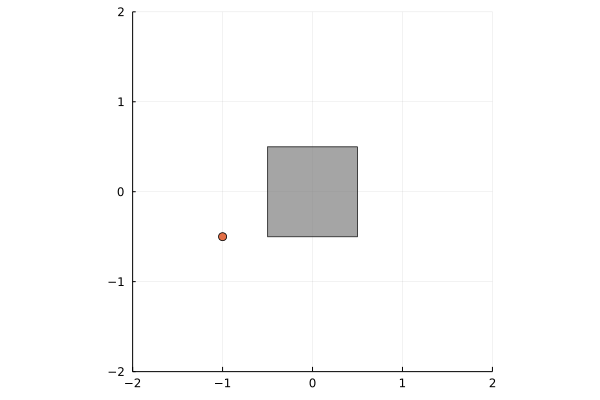

In [166]:
animation(sol.u,length(sol.t),floor(Int,length(sol.t)/tspan[2]))